In [1]:
# import sys
# !{sys.executable} -m pip install --user shap

In [100]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import time
import itertools
import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import  PolynomialFeatures,StandardScaler, MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.tree import DecisionTreeClassifier, ExtraTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import shap
from scipy import stats
from joblib import dump, load

In [114]:
path_metadata = Path('/home/polina/private_datasets/glioma_burdenko/new_csv/meta_all.csv')
df=pd.read_csv(path_metadata)
df_mark=pd.read_excel('glioma_burdenko_data_cleaning.xlsx', sheet_name='modality_update')

Columns (0,8,23,29,34,38,39,44,45,47,53,54,56,57,60,65,66,67,69,71,72,73,74,76,80,81,83,84,85,89,95,101,102,107,109,110,111,114,116,117,119,126,134,135,138,139,140,143,144,146,147,149,154,155,158,165,166,168,169,172,175,178,186,188,189,192,193,194,195,197,199,202,203,204,205,206,207,208,211,212,221,226,227,228,231,233,238,242,243,249,262,263,265,266,267,268,269,271,273,274,280,286,287,288,289,291,294,296,297,298,299,304,305,306,307,308,310,311,314,316,317,318,319,320,321,324,325,326,327,328,333,334,335,336,337,338,341,342,343,347,348,349,350,351,352,355,356,358,359,360,361,362,363,365,366,367,368,369,371,372,373,375,376,377,378,379,380,381,382,387,390,392,397,403,414,415,416,419,420,428,429,440) have mixed types.Specify dtype option on import or set low_memory=False.


In [11]:
train_df = pd.DataFrame(columns=['SeriesInstanceUID', 'RepetitionTime', 'EchoTime', 'FlipAngle', 'ContrastBolusAgent', 'Modality'])
test_df= pd.DataFrame(columns=['SeriesInstanceUID', 'RepetitionTime', 'EchoTime', 'FlipAngle', 'ContrastBolusAgent'])

for i in tqdm(range(len(df_mark))):
    uid=df_mark.iloc[i]['SeriesInstanceUID IMAGE']
    if not df[df['SeriesInstanceUID'] == uid].empty:
        new_row = {'SeriesInstanceUID': uid, 'RepetitionTime':df[df['SeriesInstanceUID'] == uid]['RepetitionTime'].values[0], 'EchoTime':df[df['SeriesInstanceUID'] == uid]['EchoTime'].values[0], 'FlipAngle': df[df['SeriesInstanceUID'] == uid]['FlipAngle'].values[0],'ContrastBolusAgent':df[df['SeriesInstanceUID'] == uid]['ContrastBolusAgent'].values[0], 'Modality':df_mark.iloc[i]['Modality']}
        train_df = train_df.append(new_row, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2133/2133 [05:58<00:00,  5.95it/s]


In [12]:
# train_df.to_csv('train_df.csv')

In [13]:
df_without_nan=pd.read_csv('train_df.csv')
df_without_nan.dropna(subset=['RepetitionTime'], inplace=True)
df_without_nan.dropna(subset=['Modality'], inplace=True)
df_without_nan = df_without_nan.drop(df_without_nan[df_without_nan['Modality']=='T1/T1c'].index)

In [15]:
df_without_nan.loc[df_without_nan['ContrastBolusAgent'] !=None,'ContrastBolusAgent']=1
df_without_nan.loc[df_without_nan['ContrastBolusAgent'] ==None,'ContrastBolusAgent']=0
df_without_nan['EchoTime'] =df_without_nan['EchoTime'].fillna(0)
df_without_nan['FlipAngle'] =df_without_nan['FlipAngle'].fillna(0)

In [16]:
df_without_nan

,Unnamed: 0,SeriesInstanceUID,RepetitionTime,EchoTime,FlipAngle,ContrastBolusAgent,Modality
1,1,1.2.840.113619.2.244.6945.1127390.23777.142433...,9502.000000,123.120,90.0,1,Flair
2,2,1.3.46.670589.11.8002.5.0.7452.201609171236215...,11000.000000,140.000,90.0,1,Flair
5,5,1.3.46.670589.11.10507.5.0.752.201702201200089...,6894.250977,110.000,90.0,1,T2
6,6,1.3.46.670589.11.33489.5.0.4984.20160212150626...,7459.892090,100.000,90.0,1,T2
7,7,1.2.840.113619.2.275.10502719.2141559.24330.15...,7547.000000,98.400,90.0,1,T2
...,...,...,...,...,...,...,...
1753,1753,1.3.46.670589.11.20098.5.0.7800.20140322182033...,450.000214,15.000,69.0,1,T1c
1769,1769,1.3.12.2.1107.5.2.6.23898.30000015011912360918...,604.000000,10.000,90.0,1,T1
1770,1770,1.3.12.2.1107.5.2.6.23898.30000015011912360918...,500.000000,9.300,90.0,1,T1c
1777,1777,1.2.840.113619.2.312.6945.1127356.12758.136671...,9502.000000,126.684,90.0,1,Flair


In [17]:
np.unique(df_without_nan['Modality'],return_counts=True)

(array(['Flair', 'T1', 'T1c', 'T2'], dtype=object),
 array([240, 156, 188, 267]))

Nearest Neighbors
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        70
           1       0.96      0.96      0.96        79
           2       0.56      0.53      0.54        47
           3       0.65      0.67      0.66        60

    accuracy                           0.81       256
   macro avg       0.78      0.78      0.78       256
weighted avg       0.81      0.81      0.81       256

Accuracy: 0.8125
Linear SVM
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        70
           1       0.83      0.91      0.87        79
           2       0.61      0.60      0.60        47
           3       0.67      0.70      0.68        60

    accuracy                           0.77       256
   macro avg       0.75      0.75      0.75       256
weighted avg       0.77      0.77      0.77       256

Accuracy: 0.76953125
RBF SVM
              precision    recall  f1-score   support



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


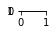

In [18]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
X=df_without_nan[['RepetitionTime', 'EchoTime', 'FlipAngle', 'ContrastBolusAgent']]  
y=pd.factorize(df_without_nan['Modality'].values)[0]

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)
# iterate over classifiers
for name, clf in zip(names, classifiers):
        ax = plt.subplot(1681, len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)
        print(name)
        print(metrics.classification_report(y_test, y_pred))
        print("Accuracy:",metrics.accuracy_score(y_test, y_pred))



In [19]:
clf1 = DecisionTreeClassifier(max_depth=4, random_state=1)
clf2 = RandomForestClassifier(random_state=1, n_estimators=25, max_depth=4,n_jobs=-1)
clf3 = LogisticRegression(random_state=1,
                          solver='newton-cg',multi_class='ovr', n_jobs=-1)
clf4 = SVC(kernel='rbf', random_state=1)
clf5 = GaussianNB()
clf6 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

In [20]:
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(30,14))

labels = ['DecisionTreeClassifier', 'RandomForestClassifier','LogisticRegression', 'SVC', 'GaussianNB', 'KNeighborsClassifier']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5,clf6],
                         labels,
                         itertools.product([0, 1], [0,1,2])):
  
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    print(lab)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


DecisionTreeClassifier
Accuracy: 0.80078125
RandomForestClassifier
Accuracy: 0.80078125
LogisticRegression
Accuracy: 0.79296875
SVC
Accuracy: 0.73828125
GaussianNB
Accuracy: 0.70703125
KNeighborsClassifier
Accuracy: 0.8125


<Figure size 2160x1008 with 0 Axes>

In [21]:
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
randforest = RandomForestClassifier(random_state=1, n_estimators=25, max_depth=4,n_jobs=-1)
# gaus = GaussianNB()
model1 = make_pipeline(StandardScaler(), PolynomialFeatures(degree=6), knn)
model2 = make_pipeline(MinMaxScaler(),  PolynomialFeatures(degree=8),GaussianRandomProjection(random_state=1, n_components=10), randforest)

In [22]:
gs = gridspec.GridSpec(1,2)
fig = plt.figure(figsize=(30,12))

labels = ['KNeighborsClassifier', 'RandomForestClassifier']
for clf, lab, grd in zip([model1, model2],
                         labels,
                         [[0,0],[0,1]]):
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    print(lab)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    

KNeighborsClassifier
Accuracy: 0.81640625
RandomForestClassifier
Accuracy: 0.8125


<Figure size 2160x864 with 0 Axes>

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        70
           1       0.96      0.96      0.96        79
           2       0.57      0.60      0.58        47
           3       0.67      0.65      0.66        60

    accuracy                           0.82       256
   macro avg       0.79      0.79      0.79       256
weighted avg       0.82      0.82      0.82       256

Accuracy: 0.8203125
[[67  3  0  0]
 [ 3 76  0  0]
 [ 0  0 28 19]
 [ 0  0 21 39]]


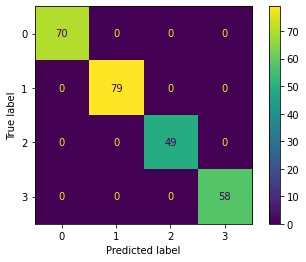

In [23]:
clf= SVC(gamma=2, C=1)

X=df_without_nan[['RepetitionTime', 'EchoTime', 'FlipAngle', 'ContrastBolusAgent']]  
y=pd.factorize(df_without_nan['Modality'].values)[0]

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)
# iterate over classifiers
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(clf, X_test, y_pred)  
  

In [24]:
pd.factorize(df_without_nan['Modality'].values)[1]

array(['Flair', 'T2', 'T1', 'T1c'], dtype=object)

# More feature

In [23]:
path_metadata = Path('/home/polina/private_datasets/glioma_burdenko/new_csv/meta_all.csv')
df=pd.read_csv(path_metadata)
df_mark=pd.read_excel('glioma_burdenko_data_cleaning.xlsx', sheet_name='modality_update')

/home/polina/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,8,23,29,34,38,39,44,45,47,53,54,56,57,60,65,66,67,69,71,72,73,74,76,80,81,83,84,85,89,95,101,102,107,109,110,111,114,116,117,119,126,134,135,138,139,140,143,144,146,147,149,154,155,158,165,166,168,169,172,175,178,186,188,189,192,193,194,195,197,199,202,203,204,205,206,207,208,211,212,221,226,227,228,231,233,238,242,243,249,262,263,265,266,267,268,269,271,273,274,280,286,287,288,289,291,294,296,297,298,299,304,305,306,307,308,310,311,314,316,317,318,319,320,321,324,325,326,327,328,333,334,335,336,337,338,341,342,343,347,348,349,350,351,352,355,356,358,359,360,361,362,363,365,366,367,368,369,371,372,373,375,376,377,378,379,380,381,382,387,390,392,397,403,414,415,416,419,420,428,429,440) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
train_df = pd.DataFrame(columns=['SeriesInstanceUID', 'RepetitionTime', 'EchoTime', 'EchoTrainLength', 'FlipAngle', 'ImagingFrequency', 'NumberOfAverages', 'MagneticFieldStrength', 'EchoNumbers', 'ContrastBolusAgent', 'Modality'])

for i in tqdm(range(len(df_mark))):
    uid=df_mark.iloc[i]['SeriesInstanceUID IMAGE']
    if not df[df['SeriesInstanceUID'] == uid].empty:
        new_row = {'SeriesInstanceUID': uid, 'RepetitionTime':df[df['SeriesInstanceUID'] == uid]['RepetitionTime'].values[0], 'EchoTime':df[df['SeriesInstanceUID'] == uid]['EchoTime'].values[0], 'EchoTrainLength' :df[df['SeriesInstanceUID'] == uid]['EchoTrainLength'].values[0],  'ImagingFrequency' : df[df['SeriesInstanceUID'] == uid]['ImagingFrequency'].values[0], 'NumberOfAverages':df[df['SeriesInstanceUID'] == uid]['NumberOfAverages'].values[0], 'MagneticFieldStrength' :df[df['SeriesInstanceUID'] == uid]['MagneticFieldStrength'].values[0], 'EchoNumbers':df[df['SeriesInstanceUID'] == uid]['EchoNumbers'].values[0],  'FlipAngle': df[df['SeriesInstanceUID'] == uid]['FlipAngle'].values[0],'ContrastBolusAgent':df[df['SeriesInstanceUID'] == uid]['ContrastBolusAgent'].values[0], 'Modality':df_mark.iloc[i]['Modality']}
        #append row to the dataframe
        train_df = train_df.append(new_row, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2133/2133 [11:52<00:00,  2.99it/s]


In [91]:
# train_df.to_csv('train_df_more_feature.csv')
train_df=pd.read_csv('train_df_more_feature.csv')

In [92]:
train_df.dropna(subset=['RepetitionTime'], inplace=True)
train_df.dropna(subset=['Modality'], inplace=True)
train_df = train_df.drop(train_df[train_df['Modality']=='T1/T1c'].index)
train_df.loc[train_df['ContrastBolusAgent'] !=None,'ContrastBolusAgent']=1
train_df.loc[train_df['ContrastBolusAgent'] ==None,'ContrastBolusAgent']=0
# train_df['EchoTime'] =train_df['EchoTime'].fillna(0)
# train_df['FlipAngle'] =train_df['FlipAngle'].fillna(0)
# train_df['EchoTrainLength'] =train_df['EchoTrainLength'].fillna(0)
# train_df['ImagingFrequency'] =train_df['ImagingFrequency'].fillna(0)
# train_df['NumberOfAverages'] =train_df['NumberOfAverages'].fillna(0)
# train_df['MagneticFieldStrength'] =train_df['MagneticFieldStrength'].fillna(0)
# train_df['EchoNumbers'] =train_df['EchoNumbers'].fillna(0)
train_df.dropna(subset=['EchoTime'], inplace=True)
train_df.dropna(subset=['FlipAngle'], inplace=True)
train_df.dropna(subset=['EchoTrainLength'], inplace=True)
train_df.dropna(subset=['ImagingFrequency'], inplace=True)
train_df.dropna(subset=['NumberOfAverages'], inplace=True)
train_df.dropna(subset=['MagneticFieldStrength'], inplace=True)
train_df.dropna(subset=['EchoNumbers'], inplace=True)

In [93]:
train_df

,Unnamed: 0,SeriesInstanceUID,RepetitionTime,EchoTime,EchoTrainLength,FlipAngle,ImagingFrequency,NumberOfAverages,MagneticFieldStrength,EchoNumbers,ContrastBolusAgent,Modality
1,1,1.2.840.113619.2.244.6945.1127390.23777.142433...,9502.000000,123.120,1.0,90.0,63.861248,1.0,1.5,1.0,1,Flair
2,2,1.3.46.670589.11.8002.5.0.7452.201609171236215...,11000.000000,140.000,52.0,90.0,63.881927,2.0,1.5,1.0,1,Flair
5,5,1.3.46.670589.11.10507.5.0.752.201702201200089...,6894.250977,110.000,15.0,90.0,63.900809,3.0,1.5,1.0,1,T2
6,6,1.3.46.670589.11.33489.5.0.4984.20160212150626...,7459.892090,100.000,15.0,90.0,63.881809,1.0,1.5,1.0,1,T2
7,7,1.2.840.113619.2.275.10502719.2141559.24330.15...,7547.000000,98.400,24.0,90.0,63.871162,1.0,1.5,1.0,1,T2
...,...,...,...,...,...,...,...,...,...,...,...,...
1753,1753,1.3.46.670589.11.20098.5.0.7800.20140322182033...,450.000214,15.000,1.0,69.0,63.903840,1.0,1.5,1.0,1,T1c
1769,1769,1.3.12.2.1107.5.2.6.23898.30000015011912360918...,604.000000,10.000,1.0,90.0,63.695920,2.0,1.5,0.0,1,T1
1770,1770,1.3.12.2.1107.5.2.6.23898.30000015011912360918...,500.000000,9.300,1.0,90.0,63.695921,2.0,1.5,0.0,1,T1c
1777,1777,1.2.840.113619.2.312.6945.1127356.12758.136671...,9502.000000,126.684,1.0,90.0,127.753685,1.0,3.0,1.0,1,Flair


              precision    recall  f1-score   support

           0       0.97      0.96      0.97        72
           1       0.96      0.96      0.96        80
           2       0.62      0.48      0.54        42
           3       0.60      0.74      0.67        47

    accuracy                           0.83       241
   macro avg       0.79      0.79      0.78       241
weighted avg       0.84      0.83      0.83       241

Accuracy: 0.8340248962655602
[[69  3  0  0]
 [ 2 77  0  1]
 [ 0  0 20 22]
 [ 0  0 12 35]]


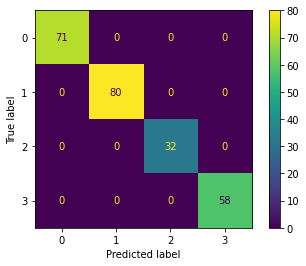

In [35]:
clf= SVC(gamma=2, C=1)

X=train_df[['RepetitionTime', 'EchoTime', 'EchoTrainLength', 'FlipAngle', 'ImagingFrequency', 'NumberOfAverages', 'MagneticFieldStrength', 'EchoNumbers', 'ContrastBolusAgent']]
y=pd.factorize(train_df['Modality'].values)[0]

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)
# iterate over classifiers
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(clf, X_test, y_pred)  

Nearest Neighbors
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        70
           1       0.94      0.99      0.96        79
           2       0.59      0.49      0.53        47
           3       0.64      0.72      0.68        60

    accuracy                           0.82       256
   macro avg       0.79      0.78      0.78       256
weighted avg       0.81      0.82      0.81       256

Accuracy: 0.81640625
Linear SVM
              precision    recall  f1-score   support

           0       0.92      0.84      0.88        70
           1       0.87      0.91      0.89        79
           2       0.63      0.47      0.54        47
           3       0.64      0.78      0.70        60

    accuracy                           0.78       256
   macro avg       0.76      0.75      0.75       256
weighted avg       0.78      0.78      0.78       256

Accuracy: 0.78125
RBF SVM
              precision    recall  f1-score   support


/home/polina/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/polina/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/polina/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/polina/.local/lib/python3.8/site-p

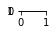

In [37]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=4),
    RandomForestClassifier(max_depth=4, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)
# iterate over classifiers
for name, clf in zip(names, classifiers):
        ax = plt.subplot(1681, len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)
        print(name)
        print(metrics.classification_report(y_test, y_pred))
        print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [40]:
clf1 = DecisionTreeClassifier(max_depth=4, random_state=1)
clf2 = RandomForestClassifier(random_state=1, n_estimators=25, max_depth=4,n_jobs=-1)
clf3 = LogisticRegression(random_state=1,
                          solver='newton-cg',multi_class='ovr', n_jobs=-1)
clf4 = SVC(kernel='rbf', random_state=1)
clf5 = GaussianNB()
clf6 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

In [41]:
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(30,14))

labels = ['DecisionTreeClassifier', 'RandomForestClassifier','LogisticRegression', 'SVC', 'GaussianNB', 'KNeighborsClassifier']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5,clf6],
                         labels,
                         itertools.product([0, 1], [0,1,2])):
  
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    print(lab)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

DecisionTreeClassifier
Accuracy: 0.8046875
RandomForestClassifier
Accuracy: 0.79296875
LogisticRegression
Accuracy: 0.78515625
SVC
Accuracy: 0.76953125
GaussianNB
Accuracy: 0.74609375
KNeighborsClassifier
Accuracy: 0.81640625


<Figure size 2160x1008 with 0 Axes>

In [42]:
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
randforest = RandomForestClassifier(random_state=1, n_estimators=25, max_depth=4,n_jobs=-1)
# gaus = GaussianNB()
model1 = make_pipeline(StandardScaler(), PolynomialFeatures(degree=6), knn)
model2 = make_pipeline(MinMaxScaler(),  PolynomialFeatures(degree=8),GaussianRandomProjection(random_state=1, n_components=10), randforest)

In [43]:
gs = gridspec.GridSpec(1,2)
fig = plt.figure(figsize=(30,12))

labels = ['KNeighborsClassifier', 'RandomForestClassifier']
for clf, lab, grd in zip([model1, model2],
                         labels,
                         [[0,0],[0,1]]):
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    print(lab)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    

KNeighborsClassifier
Accuracy: 0.78515625
RandomForestClassifier
Accuracy: 0.80078125


<Figure size 2160x864 with 0 Axes>

In [52]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [53]:
cm = confusion_matrix(y_test, clf.predict(X_test))
modalities = ['Flair', 'T1', 'T1c', 'T2']
results = pd.DataFrame({'Flair': cm[0],
                        'T1': cm[1],
                        'T1c': cm[2],
                        'T2': cm[3]},
                        index=modalities)
print(results)
print("Accuracy:",metrics.accuracy_score(y_test, clf.predict(X_test)))

       Flair  T1  T1c  T2
Flair     70   0    0   0
T1         2  80    0   0
T1c        0   0   20  14
T2         0   0   22  33
Accuracy: 0.8423236514522822


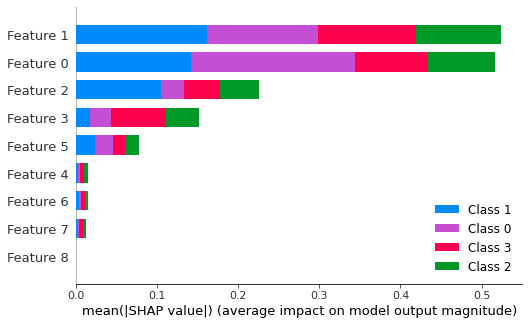

In [40]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type='bar')

In [45]:
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)
clf1 = DecisionTreeClassifier(max_depth=2)
clf1.fit(X_train, y_train)
y_pred=clf1.predict(X_test)
cmr = confusion_matrix(y_test, y_pred)
results = pd.DataFrame({'Flair': cmr[0],
                        'T1': cmr[1],
                        'T1c': cmr[2],
                        'T2': cmr[3]},
                        index=modalities)
print(results)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

       Flair  T1  T1c  T2
Flair     72   8    0   0
T1         0  72    0   0
T1c        0   0   32  15
T2         0   0   10  32
Accuracy: 0.8630705394190872


In [49]:
data_reduced = train_df[['RepetitionTime', 'EchoTime']]
# X=train_df[['RepetitionTime', 'EchoTime', 'EchoTrainLength', 'FlipAngle', 'ImagingFrequency', 'NumberOfAverages', 'MagneticFieldStrength', 'EchoNumbers', 'ContrastBolusAgent']]
y=pd.factorize(train_df['Modality'].values)[0]


Xr_train, Xr_test, yr_train, yr_test = train_test_split(data_reduced,y, test_size=0.3, stratify=y)
clf1 = RandomForestClassifier()
clf1.fit(Xr_train, yr_train)
cmr = confusion_matrix(yr_test, clf1.predict(Xr_test))
resultsr = pd.DataFrame({'Flair': cmr[0],
                        'T1': cmr[1],
                        'T1c': cmr[2],
                        'T2': cmr[3]},
                        index=modalities)
print(resultsr)
print("Accuracy:",metrics.accuracy_score(y_test, clf1.predict(Xr_test)))

       Flair  T1  T1c  T2
Flair     66   1    0   0
T1         2  74    0   0
T1c        0   0   23  21
T2         0   0   21  33
Accuracy: 0.3360995850622407


In [50]:
clf1 = DecisionTreeClassifier(max_depth=2)
clf1.fit(Xr_train, yr_train)
cmr = confusion_matrix(yr_test, clf1.predict(Xr_test))
resultsr = pd.DataFrame({'Flair': cmr[0],
                        'T1': cmr[1],
                        'T1c': cmr[2],
                        'T2': cmr[3]},
                        index=modalities)
print(resultsr)
print("Accuracy:",metrics.accuracy_score(y_test, clf1.predict(Xr_test)))

       Flair  T1  T1c  T2
Flair     59   0    0   0
T1         9  75    0   0
T1c        0   0   36  41
T2         0   0    8  13
Accuracy: 0.3360995850622407


In [95]:
X=train_df[['RepetitionTime', 'EchoTime', 'EchoTrainLength', 'FlipAngle', 'ImagingFrequency', 'NumberOfAverages', 'MagneticFieldStrength', 'EchoNumbers', 'ContrastBolusAgent']]
y=pd.factorize(train_df['Modality'].values)[0]
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)

In [96]:
params = {
    'max_depth': stats.randint(2, 10),
    'min_samples_split': stats.randint(2, 25),
    'n_estimators':stats.randint(1, 10),
    'min_samples_leaf': [5],
    'max_features': [1.],
    'random_state':[1],
}
cv = KFold(n_splits=5, shuffle=True, random_state=1)
clf = RandomForestClassifier()
rs = RandomizedSearchCV(estimator=clf,
                       param_distributions=params,
                       n_iter=1000,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=cv,
                       verbose=1,
                       random_state=1)

In [97]:
search = rs.fit(X_train, y_train)
print(search.best_params_)
cmr = confusion_matrix(y_test, rs.predict(X_test))
results = pd.DataFrame({'Flair': cmr[0],
                        'T1': cmr[1],
                        'T1c': cmr[2],
                        'T2': cmr[3]},
                        index=modalities)
print(results)
print("Accuracy:",metrics.accuracy_score(y_test, rs.predict(X_test)))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
{'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 8, 'random_state': 1}
       Flair  T1  T1c  T2
Flair     69   0    0   0
T1         3  80    0   0
T1c        0   0   22   7
T2         0   0   20  40
Accuracy: 0.8755186721991701


In [98]:
clf = RandomForestClassifier(max_depth= 4, max_features=1.0, min_samples_leaf=5, min_samples_split=12, n_estimators=7, random_state=1)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
cmr = confusion_matrix(y_test, y_pred)
results = pd.DataFrame({'Flair': cmr[0],
                        'T1': cmr[1],
                        'T1c': cmr[2],
                        'T2': cmr[3]},
                        index=modalities)
print(results)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

       Flair  T1  T1c  T2
Flair     69   0    0   0
T1         3  80    0   0
T1c        0   0   22   7
T2         0   0   20  40
Accuracy: 0.8755186721991701


In [101]:
dump(clf, 'randomforest.joblib')
# clf = load('filename.joblib') 

['randomforest.joblib']

In [112]:
def get_modality(data,path='randomforest.joblib'):
    data.loc[data['ContrastBolusAgent'] !=None,'ContrastBolusAgent']=1
    data.loc[data['ContrastBolusAgent'] ==None,'ContrastBolusAgent']=0
    label = np.array(['Flair', 'T2', 'T1', 'T1c'])
    clf = load('randomforest.joblib') 
    mod = clf.predict(data)
    return label[mod]
data = train_df[['RepetitionTime', 'EchoTime', 'EchoTrainLength', 'FlipAngle', 'ImagingFrequency', 'NumberOfAverages', 'MagneticFieldStrength', 'EchoNumbers', 'ContrastBolusAgent']]
mod = get_modality(data)

In [115]:
path_metadata = Path('/home/polina/private_datasets/glioma_burdenko/new_csv/meta_all.csv')
df=pd.read_csv(path_metadata)
feature = ['RepetitionTime', 'EchoTime', 'EchoTrainLength', 'FlipAngle', 'ImagingFrequency', 'NumberOfAverages', 'MagneticFieldStrength', 'EchoNumbers', 'ContrastBolusAgent']
mod = get_modality(df[feature])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').